In [ ]:
#NOTEBOOK CODE HEAVILY FOLLOWS
#https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [164]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
#import torch.selfim as selfim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.optim as optim

%matplotlib inline

#import pytorch-fid
import time
import datetime
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from matplotlib.animation import FuncAnimation
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm import tqdm
from torchvision import datasets, transforms, models
import torchvision.transforms as T
import torchvision
from torch.autograd import Variable
import os 
import sys
from PIL import Image

In [139]:
class Parameters:
    def __init__(self):

        self.batchSize = 64
        self.nz = 100
        self.ngf = 64
        self.ndf = 64
        self.niter = 1
        self.lr = 0.0002
        self.beta1 = 0.5
        self.cuda = True
        self.ngpu = 1
        self.manual_seed = 0
        self.imageSize = 64
        self.outf = os.path.join(sys.path[0], "model_data")
        self.netG = ''
        self.netD = ''
        self.path = "image_data/cleaned_train"

params = Parameters()

#latent vector size
params.nz = 100

#size of feature maps
params.ngf = 64
params.ndf = 64

params.cuda = True
params.ngpu = 1
params.imageSize = 64

#batch size
params.batchSize = 64

#epochs
params.niter = 201

#learning rate
params.lr = 0.0002

#beta optimizer for Adam optimizers
params.beta1 = 0.5

#Change this string out for a saved pytorch state dict, if you want to load model from saved training state.
# params.netG = os.path.join(sys.path[0], "model_data/generator_dicts/PNEUMONIA_netG_epoch_200.pth")
# params.netD = os.path.join(sys.path[0], "model_data/discriminator_dicts/PNEUMONIA_netD_epoch_200.pth")
params.netG = os.path.join(sys.path[0], "model_data/generator_dicts/NORMAL_netG_epoch_100.pth")
params.netD = os.path.join(sys.path[0], "model_data/discriminator_dicts/NORMAL_netD_epoch_100.pth")

params.path = "image_data_SEPERATED/cleaned_train_PNEUMONIA"
#number of channels (related to color)
nc = 1

In [94]:
def load_data(batch_size, path):
    """
    Load dataset.
    :return: DataLoader object
    """

    cuda_kwargs = {
        'num_workers': 1,
        'pin_memory': True,
        'shuffle': True
    } if torch.cuda.is_available() else {}

    # format image data, but do not normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    transform = transforms.Compose(
        [transforms.Grayscale(num_output_channels=1),
         transforms.Resize(params.imageSize),
         transforms.ToTensor()
        ])
    dataset = datasets.ImageFolder(path,transform)
    # load data
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        **cuda_kwargs
    )
    return loader

In [95]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            #4x4
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2,ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output
    
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

In [140]:
ngpu = int(params.ngpu)
nz = int(params.nz)
ngf = int(params.ngf)
ndf = int(params.ndf)

params.manualSeed = random.randint(1, 10000)
random.seed(params.manualSeed)
torch.manual_seed(params.manualSeed)
cudnn.benchmark = True
dataloader = load_data(params.batchSize, params.path)
if params.cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

netG = Generator(ngpu).to(device)
netG.apply(weights_init)
if params.netG != '':
    netG.load_state_dict(torch.load(params.netG))
print(netG)

netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
if params.netD != '':
    netD.load_state_dict(torch.load(params.netD))
print(netD)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [97]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(params.batchSize, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=params.lr, betas=(params.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=params.lr, betas=(params.beta1, 0.999))
epoch_counter = 0

loss_D_arr = []
loss_G_arr = []
for epoch in range(params.niter):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label,
                           dtype=real_cpu.dtype, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, params.niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        loss_D_arr.append(errD.item())
        loss_G_arr.append(errG.item())
        
    
    if epoch_counter % 20 == 0:
        vutils.save_image(real_cpu,
                '%s/real_images/real_images.png' % params.outf,
                normalize=True)
        fake = netG(fixed_noise)
        vutils.save_image(fake.detach(),
                '%s/PNEUMONIA_generated_images/fake_images_epoch_%03d.png' % (params.outf, epoch),
                normalize=True)
            # do checkpointing
    if epoch_counter % 20 == 0:
        torch.save(netG.state_dict(), '%s/generator_dicts/PNEUMONIA_netG_epoch_%d.pth' % (params.outf, epoch))
        torch.save(netD.state_dict(), '%s/discriminator_dicts/PNEUMONIA_netD_epoch_%d.pth' % (params.outf, epoch))
    epoch_counter += 1


[0/201][0/82] Loss_D: 2.1316 Loss_G: 5.6523 D(x): 0.6602 D(G(z)): 0.7728 / 0.0057
[0/201][1/82] Loss_D: 0.7126 Loss_G: 6.7528 D(x): 0.9987 D(G(z)): 0.4551 / 0.0017
[0/201][2/82] Loss_D: 0.1653 Loss_G: 6.8190 D(x): 0.9995 D(G(z)): 0.1430 / 0.0017
[0/201][3/82] Loss_D: 0.1602 Loss_G: 6.8970 D(x): 0.9991 D(G(z)): 0.1381 / 0.0015
[0/201][4/82] Loss_D: 0.0898 Loss_G: 6.9382 D(x): 0.9972 D(G(z)): 0.0801 / 0.0014
[0/201][5/82] Loss_D: 0.1147 Loss_G: 7.1793 D(x): 0.9925 D(G(z)): 0.0961 / 0.0010
[0/201][6/82] Loss_D: 0.1208 Loss_G: 7.9236 D(x): 0.9964 D(G(z)): 0.1053 / 0.0005
[0/201][7/82] Loss_D: 0.0800 Loss_G: 7.6925 D(x): 0.9787 D(G(z)): 0.0538 / 0.0007
[0/201][8/82] Loss_D: 0.0956 Loss_G: 8.2431 D(x): 0.9925 D(G(z)): 0.0805 / 0.0004
[0/201][9/82] Loss_D: 0.0613 Loss_G: 8.0025 D(x): 0.9861 D(G(z)): 0.0443 / 0.0005
[0/201][10/82] Loss_D: 0.0522 Loss_G: 7.7997 D(x): 0.9863 D(G(z)): 0.0368 / 0.0006
[0/201][11/82] Loss_D: 0.0387 Loss_G: 8.1668 D(x): 0.9982 D(G(z)): 0.0356 / 0.0004
[0/201][12/82]

In [ ]:
np.save("PNEUMONIA_loss_D_arr", loss_D_arr, allow_pickle= True)
np.save("PNEUMONIA_loss_G_arr", loss_G_arr, allow_pickle= True)

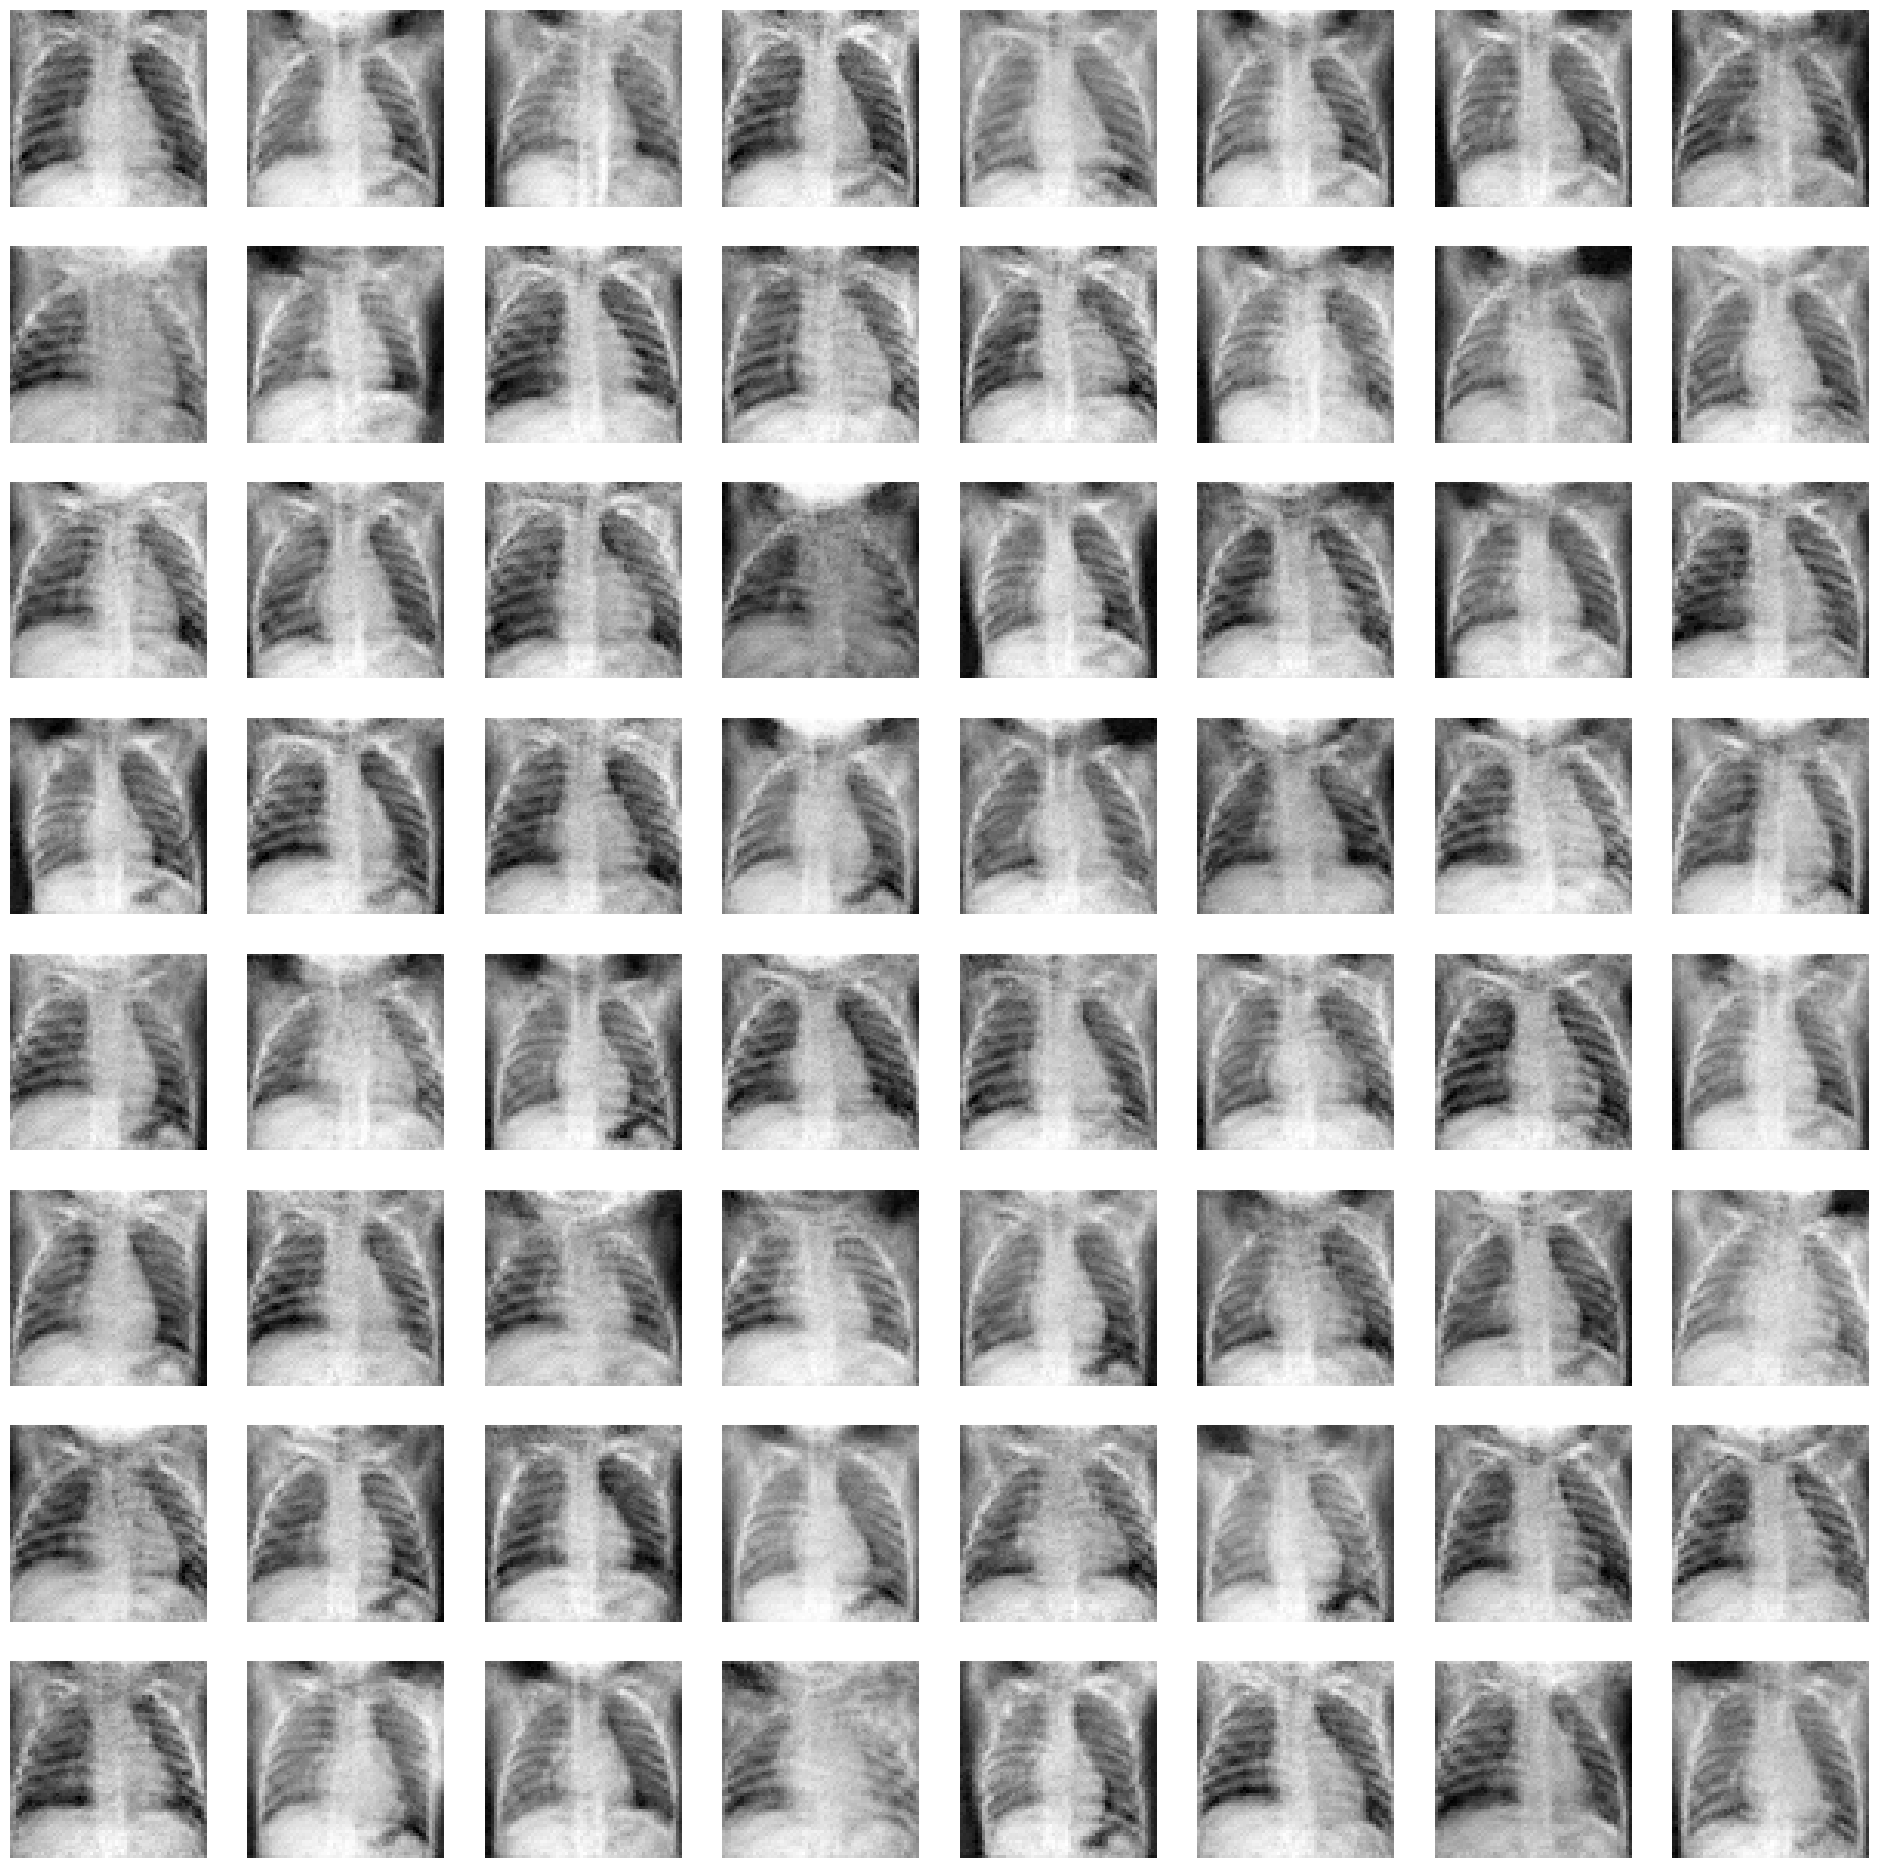

In [141]:
counter = 0
for _ in range(0,50):
    fixed_noise = torch.randn(params.batchSize, nz, 1, 1, device=device)
    img = netG(fixed_noise)
    img_array = []

    for image in img:
        img_array.append(image[0].reshape(64,64).detach().cpu())
    transform = T.ToPILImage()
    for img in img_array:
        output = transform(img.squeeze())
        output.save(os.path.join(sys.path[0], f"output_data/NORMAL/gen_normal_img{counter}.jpeg"))
        counter += 1

nrows, ncols = (8, 8)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * nrows, 3 * ncols))

counter = 0
for row in range(nrows):
    for col in range(ncols):
        axes[row, col].imshow(img_array[counter].squeeze(), cmap='gray')
        axes[row, col].axis('off')
        counter += 1


In [142]:
!python -m pytorch_fid output_data/NORMAL image_data/test/NORMAL
!python -m pytorch_fid output_data/PNEUMONIA image_data/test/PNEUMONIA

FID:  219.01159935085337



100%|██████████| 126/126 [00:45<00:00,  2.75it/s]

100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


FID:  199.51483205176544



100%|██████████| 64/64 [00:36<00:00,  1.76it/s]

100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


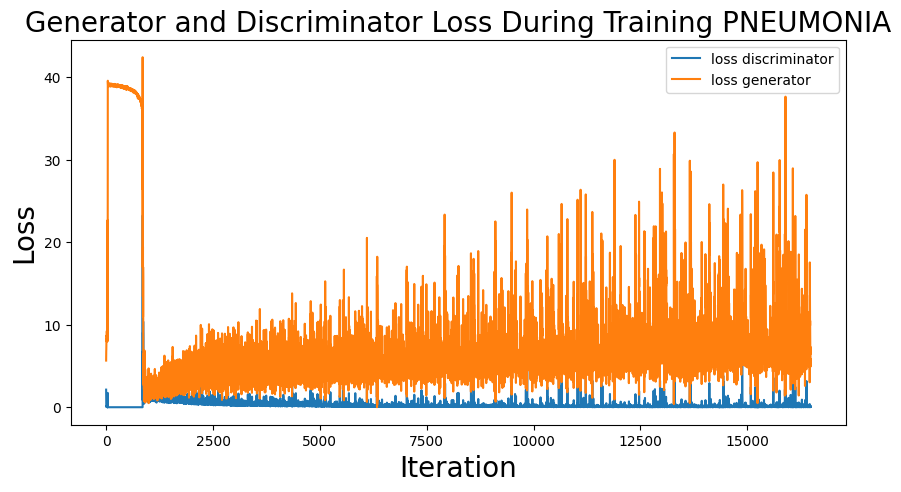

In [144]:
#Taken from DC GAN KERAS
def plot_loss_1(loss_d, loss_g):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training PNEUMONIA", fontsize=20) 
    plt.plot(loss_d, label="loss discriminator") 
    plt.plot(loss_g, label="loss generator") 
    plt.xlabel("Iteration", fontsize=20); plt.ylabel("Loss", fontsize=20) 
    plt.legend(); plt.show() 

loss_d = np.load("training_losses_time_series/PNEUMONIA_loss_D_arr.npy", allow_pickle= True)
loss_g = np.load("training_losses_time_series/PNEUMONIA_loss_G_arr.npy", allow_pickle= True)
plot_loss_1(loss_d, loss_g)

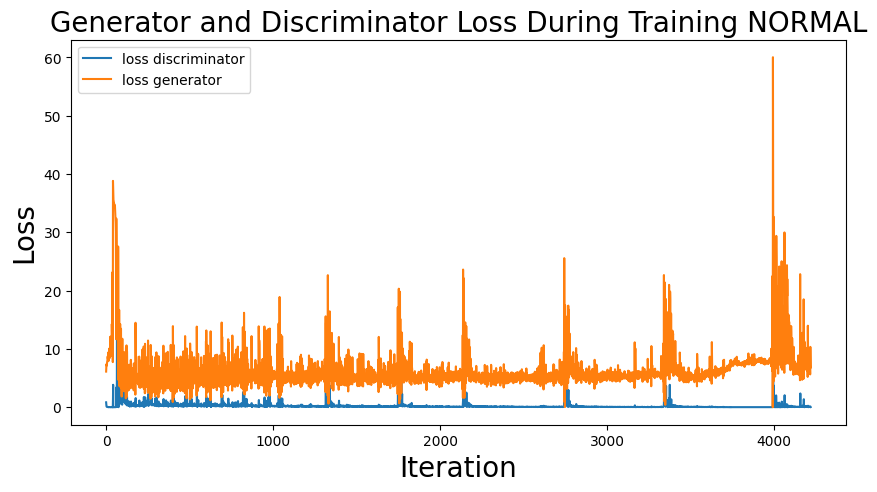

In [145]:
def plot_loss_2(loss_d, loss_g):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training NORMAL", fontsize=20) 
    plt.plot(loss_d, label="loss discriminator") 
    plt.plot(loss_g, label="loss generator") 
    plt.xlabel("Iteration", fontsize=20); plt.ylabel("Loss", fontsize=20) 
    plt.legend(); plt.show() 

loss_d = np.load("training_losses_time_series/NORMAL_loss_D_arr.npy", allow_pickle= True)
loss_g = np.load("training_losses_time_series/NORMAL_loss_G_arr.npy", allow_pickle= True)
plot_loss_2(loss_d, loss_g)

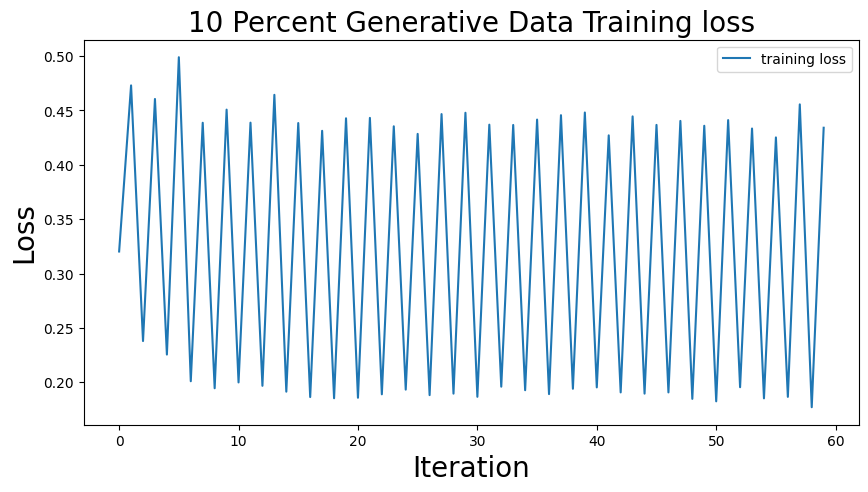

In [147]:
def plot_loss_3(loss):
    plt.figure(figsize=(10,5))
    plt.title("10 Percent Generative Data Training loss", fontsize=20) 
    plt.plot(loss, label="training loss") 
    plt.xlabel("Iteration", fontsize=20); plt.ylabel("Loss", fontsize=20) 
    plt.legend(); plt.show() 

loss = np.load("training_losses_time_series/Classifier_10_percent_generative_loss_arr.npy", allow_pickle= True)
plot_loss_3(loss)

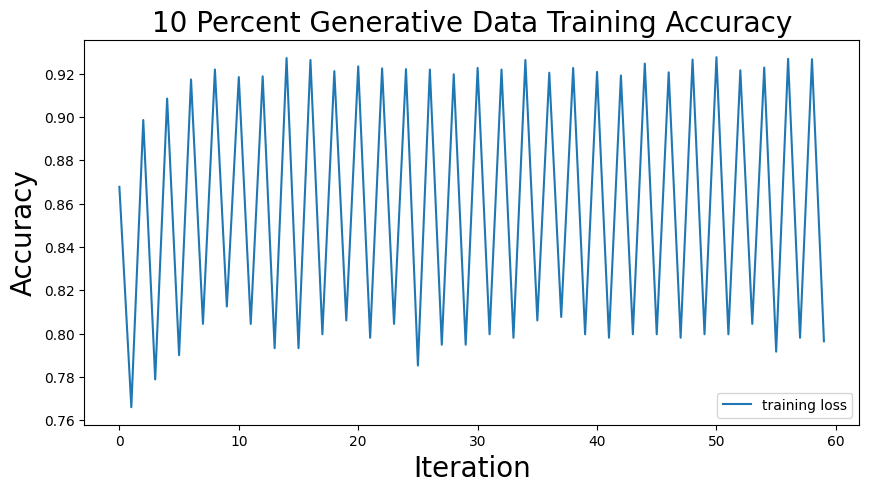

In [152]:
def plot_accuracy(acc):
    plt.figure(figsize=(10,5))
    plt.title("10 Percent Generative Data Training Accuracy", fontsize=20) 
    plt.plot(acc, label="training loss") 
    plt.xlabel("Iteration", fontsize=20); plt.ylabel("Accuracy", fontsize=20) 
    plt.legend(); plt.show() 

acc = np.load("training_losses_time_series/Classifier_10_percent_generative_acc_arr.npy", allow_pickle= True)
plot_accuracy(acc)

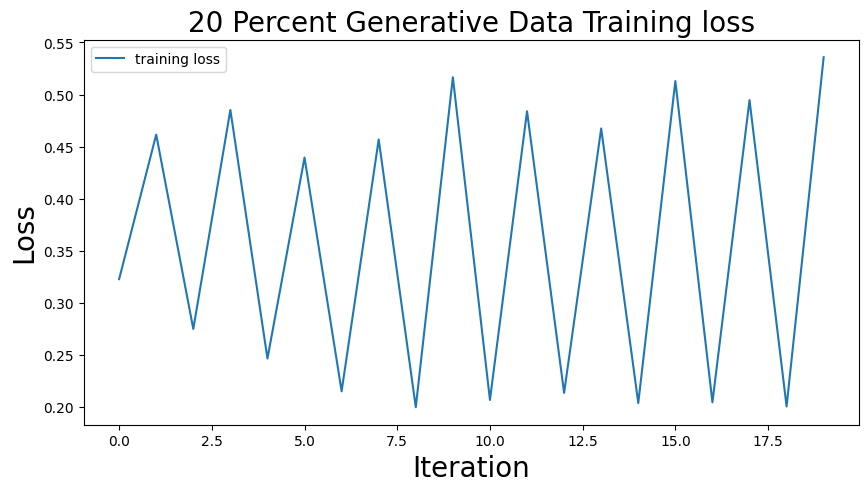

In [154]:
def plot_loss_4(loss):
    plt.figure(figsize=(10,5))
    plt.title("20 Percent Generative Data Training loss", fontsize=20) 
    plt.plot(loss, label="training loss") 
    plt.xlabel("Iteration", fontsize=20); plt.ylabel("Loss", fontsize=20) 
    plt.legend(); plt.show() 

loss = np.load("training_losses_time_series/Classifier_20_percent_generative_loss_arr.npy", allow_pickle= True)
plot_loss_4(loss)

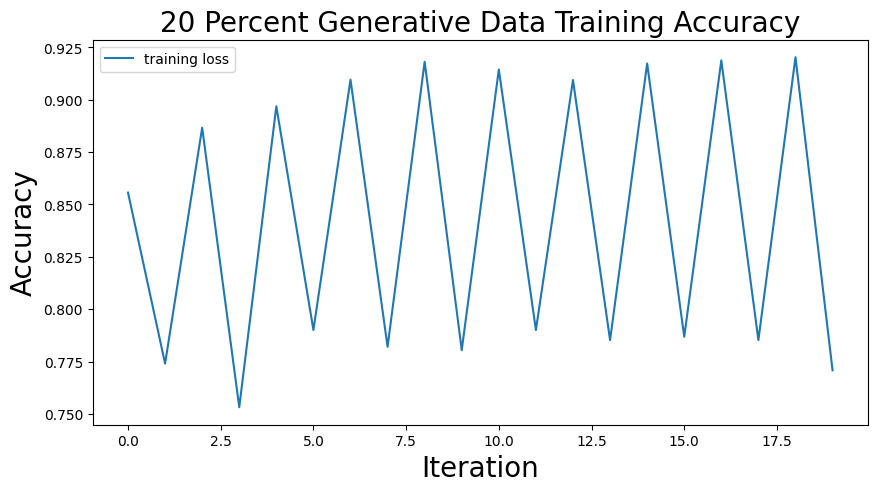

In [155]:
def plot_accuracy_2(acc):
    plt.figure(figsize=(10,5))
    plt.title("20 Percent Generative Data Training Accuracy", fontsize=20) 
    plt.plot(acc, label="training loss") 
    plt.xlabel("Iteration", fontsize=20); plt.ylabel("Accuracy", fontsize=20) 
    plt.legend(); plt.show() 

acc = np.load("training_losses_time_series/Classifier_20_percent_generative_acc_arr.npy", allow_pickle= True)
plot_accuracy_2(acc)

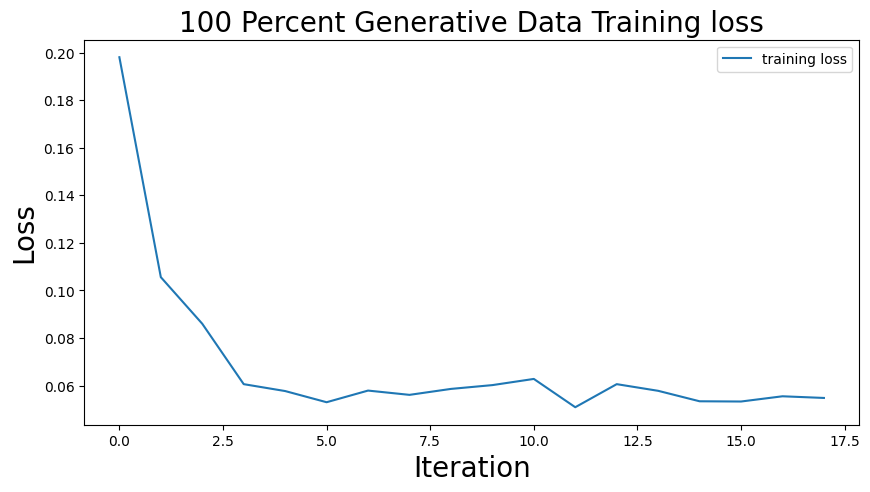

In [158]:
def plot_loss_5(loss):
    plt.figure(figsize=(10,5))
    plt.title("100 Percent Generative Data Training loss", fontsize=20) 
    plt.plot(loss, label="training loss") 
    plt.xlabel("Iteration", fontsize=20); plt.ylabel("Loss", fontsize=20) 
    plt.legend(); plt.show() 

loss = [0.1981, 0.1056, 0.0860, 0.0606, 0.0577, 0.0530, 0.0579, 0.0561, 0.0586, 0.0602, 0.0628, 0.0509, 0.0606, 0.0578, 0.0534, 0.0533, 0.0555, 0.0548]
plot_loss_5(loss)

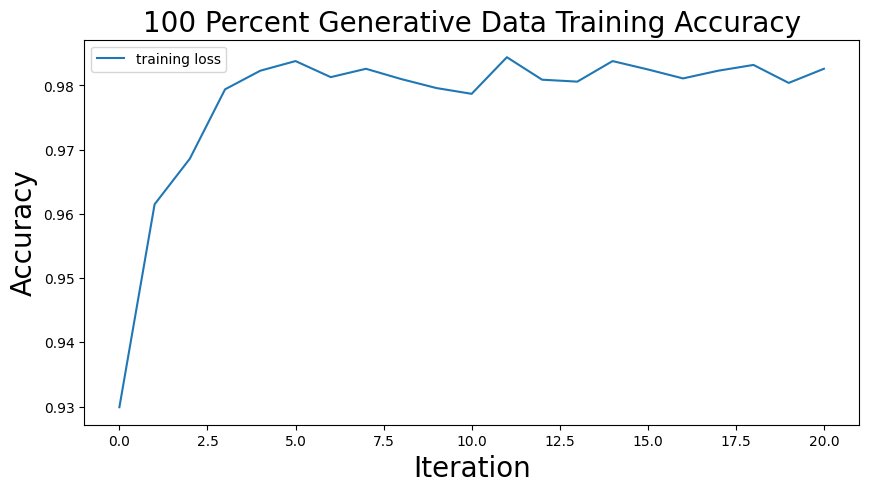

In [157]:
def plot_accuracy_3(acc):
    plt.figure(figsize=(10,5))
    plt.title("100 Percent Generative Data Training Accuracy", fontsize=20) 
    plt.plot(acc, label="training loss") 
    plt.xlabel("Iteration", fontsize=20); plt.ylabel("Accuracy", fontsize=20) 
    plt.legend(); plt.show() 

acc = [0.9299, 0.9615, 0.9686, 0.9794, 0.9823, 0.9838, 0.9813, 0.9826, 0.9810, 0.9796, 0.9787, 0.9844, 0.9809, 0.9806, 0.9838, 0.9825, 0.9811, 0.9823, 0.9832, 0.9804, 0.9826]
plot_accuracy_3(acc)

In [ ]:
#TO SEE CLASSIFIER RESULTS ON TRAINING DATA WITH VARIOUS AMOUNTS OF GENERATIVE DATA ADDED, SEE THE END OF X-RAY-CLASSIFIER.iynb.

#results summary:
#-our generative model doesn't conclusively generate images that assist in the training of the resnet152 pretrained model architecture.
#-Having the training dataset be 10% generative may improve the model performance on testing set.
#-Based on the behavior of the training of a model trained on 100% generative data, it seems like the resnet152 model is able to easily
#determine the core features of the images we generated, implying that the differences in our two classes were too easy to discern.
#This is supported by the immediate convergence of the training accuracy and the diminished training loss.
#The discrepency of behavior of training the two models separately (Generator and Discriminator Loss Normal/Pneumonia) is the likely culprit to the generative
#images of each class displaying an inherent trait that the resnet152 model is able to discern quickly. 
#